In [1]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 2.7 MB/s 
     |████████████████████████████████| 596 kB 67.6 MB/s 
     |████████████████████████████████| 895 kB 51.5 MB/s 
     |████████████████████████████████| 6.5 MB 38.7 MB/s 
     |████████████████████████████████| 67 kB 5.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [25]:
import torch
import os 
import sys
import pandas as pd
import numpy as np
from tqdm import tqdm

import re

from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt

import seaborn as sns

In [3]:
# seed
seed = 7777
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# device type
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"# available GPUs : {torch.cuda.device_count()}")
    print(f"GPU name : {torch.cuda.get_device_name()}")
else:
    device = torch.device("cpu")
print(device)

# available GPUs : 1
GPU name : Tesla P100-PCIE-16GB
cuda


In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
csv_test = pd.read_csv("/content/drive/MyDrive/NLP/sports_news_data - sports_news_data.csv")

In [6]:
csv_test.head(20)

,TITLE,CONTENT,PUBLISH_DT
0,스털링 다이빙 논란 종결?… “오른쪽 다리 접촉 있었잖아”,[스포탈코리아] 유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 ...,2021-07-15
1,"‘디 마리아 없다’ 유로X코파 베스트11, 이탈리아만 7명",[스포탈코리아] 유로 2020과 코파 아메리카 2021로 베스트11을 만든다면 어떤...,2021-07-15
2,‘슈퍼컴퓨터 예측’ 맨시티 우승-맨유 4위… 토트넘은 ‘6위’,[스포탈코리아] 새 시즌이 시작하기도 전에 슈퍼컴퓨터가 예상한 순위가 나왔다.\n\...,2021-07-15
3,"“이재성, 완벽한 프로… 마인츠서 성공할 것” 킬 디렉터의 애정 듬뿍 응원",[스포탈코리아] 홀슈타인 킬 우베 스토버 디렉터가 이재성을 향해 응원 메시지를 띄웠...,2021-07-15
4,"‘홈킷과 딴판’ 바르사 팬들, NEW 어웨이 셔츠 호평… “가장 좋아하는 색!”",[스포탈코리아] FC 바르셀로나가 새 시즌 원정 유니폼을 공개했다. 팬들은 만족스럽...,2021-07-15
5,"긴급 수혈된 바르사 NO.9, 1년 반 만에 떠난다… ‘EPL행 유력’",[스포탈코리아] FC 바르셀로나는 새 시즌을 앞두고 선수단 정리가 한창이다. 잉여 ...,2021-07-15
6,"[김남구의 유럽통신] 황의조, 손흥민 소속사와 손잡다… CAA Base와 계약",[스포탈코리아=파리(프랑스)] 황의조(지롱댕 드 보르도)가 한국 선수로는 3번째로 ...,2021-07-15
7,"""메시 종신은 축복!""…스폰서 5년 더 보장, 바르셀로나 함박웃음",[스포탈코리아] 리오넬 메시(34)가 FC바르셀로나에 남는다. 연봉을 절반 삭감하지...,2021-07-15
8,"[오피셜] 눈물 흘렸던 '37세 전설' 로번, 두 번째 현역 은퇴 발표",[스포탈코리아] 네덜란드 축구스타 아르연 로번(37)이 현역 은퇴를 밝혔다. \n\...,2021-07-15
9,"100세' 메시팬 할아버지, 748골 수기 작성…메시도 감사 인사",[스포탈코리아] 리오넬 메시(34)는 프로 데뷔하고 748골을 터뜨렸다. 전산화 하...,2021-07-15


### 크롤링 상에서 생긴 쓸모 없는 문구 처리 

In [7]:
trimmed_data=csv_test.dropna().copy()
drop_list = []
for i in range(len(trimmed_data)):
  if type(trimmed_data["CONTENT"].iloc[i]) != type("문자열"):
    j = trimmed_data.iloc[i].name
    drop_list.append(j)
    continue

  trimmed_data["CONTENT"].iloc[i] = " ".join(trimmed_data["CONTENT"].iloc[i].split())
  rmve_bracket = "\[.*\]|\(.*\)|\<.+\>"
  trimmed_data["CONTENT"].iloc[i] = re.sub(rmve_bracket,"",trimmed_data["CONTENT"].iloc[i])
  mkd_mark = "[가-힣]{1,4}\s기자\=\s|사진=[가-힣]+"
  trimmed_data["CONTENT"].iloc[i] = re.sub(mkd_mark,"",trimmed_data["CONTENT"].iloc[i])
  trimmed_data["CONTENT"].iloc[i] = re.sub(r"[^\w\d가-힣\s+]","",trimmed_data["CONTENT"].iloc[i]).strip()
  trimmed_data["TITLE"].iloc[i] = re.sub(r"[^a-zA-Z0-9가-힣\s+]","",trimmed_data["TITLE"].iloc[i]).strip()

  if len(trimmed_data["CONTENT"].iloc[i]) < 20 :
    j = trimmed_data.iloc[i].name
    drop_list.append(j)

trimmed_data = trimmed_data.drop(index = drop_list)

In [8]:
len(trimmed_data)

7235

### 띄어쓰기 및 불용어 처리

In [9]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 2.7 MB/s 
     |████████████████████████████████| 448 kB 80.7 MB/s 


In [10]:
# 한국어 불용어 리스트 크롤링
import requests
from bs4 import BeautifulSoup

url = "https://www.ranks.nl/stopwords/korean"
response = requests.get(url, verify = False)

if response.status_code == 200:
    soup = BeautifulSoup(response.text,'html.parser')
    content = soup.select_one('#article178ebefbfb1b165454ec9f168f545239 > div.panel-body > table > tbody > tr')
    stop_words=[]
    for x in content.strings:
        x=x.strip()
        if x:
            stop_words.append(x)
    print(f"# Korean stop words: {len(stop_words)}")
else:
    print(response.status_code)

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


# Korean stop words: 677


In [11]:
from konlpy.tag import Okt
okt = Okt()
for i in tqdm(range(len(trimmed_data))):
  temp_data = okt.morphs(trimmed_data["CONTENT"].iloc[i])
  temp_list = []
  
  for word in temp_data:
    if word in stop_words: continue
    temp_list.append(word)
  
  trimmed_data["CONTENT"].iloc[i] = " ".join(temp_list)
  
  temp_data = okt.morphs(trimmed_data["TITLE"].iloc[i])
  temp_list = []

  for word in temp_data:
    if word in stop_words: continue
    temp_list.append(word)
  
  trimmed_data["TITLE"].iloc[i] = " ".join(temp_list)

100%|██████████| 7235/7235 [03:04<00:00, 39.23it/s]


In [12]:
trimmed_data.head()

,TITLE,CONTENT,PUBLISH_DT
0,스털링 다이빙 논란 종결 오른쪽 다리 접촉 있었잖아,유럽 축구 연맹 주목 했다 수비수 볼 터치 하지 않았다고 봤다 멜레 오른쪽 다리 스...,2021-07-15
1,디 마리아 없다 유로 X 코파 베스트 11 이탈리아 만 7 명,유로 2020 코파 아메리카 2021 베스트 11 만든다면 모습 일까 지난달 시작 ...,2021-07-15
2,슈퍼컴퓨터 예측 맨시티 우승 맨유 4 위 토트넘 은 6 위,새 시즌 시작 하기도 전 슈퍼컴퓨터 예상 한 순위 나왔다 영국 매체 스포츠 바이블 ...,2021-07-15
3,이재성 완벽한 프로 마인츠 서 성공할 킬 디렉터 애정 듬뿍 응원,홀슈타인 킬 우베 스토 버 디렉터 이재성 향 해 응원 메시지 띄웠다 이재성 은 20...,2021-07-15
4,홈킷 딴판 바르사 팬 NEW 웨이 셔츠 호평 가장 좋아하는 색,FC 바르셀로나 새 시즌 원정 유니폼 공개 했다 팬 은 만족스럽다는 반응 이다 바르...,2021-07-15


#Abstractive summarization

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader,random_split
from tqdm import tqdm

In [14]:
class CustomDataset(Dataset):
  def __init__(
      self,
      data,
      tokenizer,
      text_max_token_len: int = 512,
      summary_max_token_len : int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.text_max_token_len = text_max_token_len
    self.summary_max_token_len = summary_max_token_len

  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, index):
    data_row = self.data.iloc[index]

    text = data_row['CONTENT']

    text_encoding = tokenizer(
        text,
        max_length = self.text_max_token_len,
        padding = "max_length",
        truncation = True,
        return_attention_mask = True,
        add_special_tokens = True,
        return_tensors = "pt"
    )

    summary_encoding = tokenizer(
        text,
        max_length = self.summary_max_token_len,
        padding = "max_length",
        truncation = True,
        return_attention_mask = True,
        add_special_tokens = True,
        return_tensors = "pt"
    )

    labels = summary_encoding["input_ids"]

    return dict(
        text = text,
        summary = data_row["TITLE"],
        text_input_ids = text_encoding["input_ids"].flatten(),
        text_attention_mask = text_encoding["attention_mask"].flatten(),
        labels = labels.flatten(),
        labels_attention_mask = summary_encoding["attention_mask"].flatten()
    )


In [15]:
tokenizer = AutoTokenizer.from_pretrained(
  'kakaobrain/kogpt', revision='KoGPT6B-ryan1.5b-float16',  # or float32 version: revision=KoGPT6B-ryan1.5b
  bos_token='[BOS]', eos_token='[EOS]', unk_token='[UNK]', pad_token='[PAD]', mask_token='[MASK]'
)

Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

In [16]:
text = trimmed_data['TITLE'].iloc[3]

text_encoding = tokenizer(
        text,
        max_length = 512,
        padding = "max_length",
        truncation = True,
        return_attention_mask = True,
        add_special_tokens = True,
        return_tensors = "pt",
    )
print(text_encoding['input_ids'])
tokenizer.decode(text_encoding['input_ids'].flatten())

tensor([[20835,   494,  4942,   393,  1336, 62776,   661,  1994,   584,  7772,
         26198,  9611, 21267,  7656,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,  

'이재성 완벽한 프로 마인츠 서 성공할 킬 디렉터 애정 듬뿍 응원[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD

In [28]:
whole_dataset = CustomDataset(trimmed_data,tokenizer)

train_set_num = len(trimmed_data)//5*4
train_dataset , test_dataset = random_split(whole_dataset, [train_set_num,len(trimmed_data)-train_set_num])
train_dataloader = DataLoader(train_dataset, batch_size = 8, shuffle=True)
test_dataloader =  DataLoader(test_dataset, batch_size = 8, shuffle=False)

In [29]:
next(iter(train_dataloader))

{'labels': tensor([[37385,  7298,   689,  ..., 16918,  4105,   374],
         [ 2774,  1960,  3406,  ...,  1356,  2774,  1960],
         [ 7183, 14111, 17784,  ...,     3,     3,     3],
         ...,
         [16950,  4570,  2267,  ...,   374,   881,  1572],
         [  912, 23521, 61621,  ..., 17431, 20808,  1090],
         [61202,  4058, 50895,  ...,   374,   812,   409]]),
 'labels_attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 'summary': ['김민재 포르투 대신 터키 가나 개인 조건 마음 기울어',
  '오피 셜 대표팀 최초 여성 감독 탄생 U 20 팀 황 인선 감독 선임',
  '바르사 먹튀 주급 제안 벙쪘다 길 래',
  '메시 닮은 특별한 라멜라 보내고 받을 유망 주 반했다',
  '맨유 떠나겠다 선언 한 시즌 1 골 공격수 스페인 뛰고 싶다',
  '본전 무승부 벨 감독 8 강 앞두고 자신감 얻었다',
  '토트넘 요 리스 대체 출전 0 맨유 GK 노린다',
  '성폭행 혐의 잉글랜드 공격 자원 대표팀 도 날아갔 감독 발탁 배제'],
 'text': ['괴물 김민재 유럽 진출 첫 무대 는 터키 될 전망 이다 축구 계 관계자 따르면 김민재 는 터키 한 클럽 보내

In [24]:
text_token_counts, summary_token_counts = [] , []

for _, row in trimmed_data.iterrows():
  text_token_count = len(tokenizer.encode(row['CONTENT']))
  text_token_counts.append(text_token_count)

  summary_token_count = len(tokenizer.encode(row['TITLE']))
  summary_token_counts.append(summary_token_count)


Text(0.5, 1.0, 'summary text token counts')

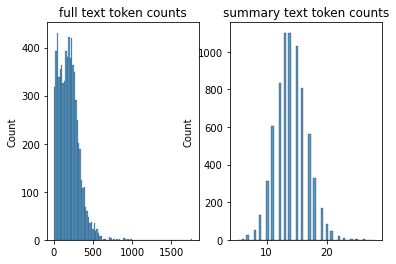

In [27]:
fig, (ax1,ax2) = plt.subplots(1,2)

sns.histplot(text_token_counts,ax=ax1)
ax1.set_title("full text token counts")

sns.histplot(summary_token_counts,ax=ax2)
ax2.set_title("summary text token counts")

# Model-Load
- 네이버의 하이퍼클로바
- 기반은 GPT-3
- 기본적으로 생성에 강점이 있는 모델이라 선정함
- "train 코드 작성 부탁드려요"

In [30]:
model = AutoModelForCausalLM.from_pretrained(
    'kakaobrain/kogpt', revision='KoGPT6B-ryan1.5b-float16',  # or float32 version: revision=KoGPT6B-ryan1.5b
    pad_token_id=tokenizer.eos_token_id,
    torch_dtype='auto', low_cpu_mem_usage=True
    ).to(device='cuda', non_blocking=True)

N_EPOCHS = 3
optimizer = SGD(model.paramets(),lr =0.0001)
scheduler = CosineAnnealingWarmRestarts(optimizer,T_0 = 1,T_mult = 1)

KeyboardInterrupt: ignored

In [ ]:
for epoch in range(N_EPOCHS):
    
    print(f"*****Epoch {epoch} Train Start*****")
    print(f"*****Epoch {epoch} Total Step {len(train_dataloader)}*****")
    total_loss, batch_loss, batch_step = 0,0,0

    for step, batch in enumerate(train_dataloader):
        batch_step+=1
        text_attention_mask = batch["text_attention_mask"].to(device)
        text_input_ids = batch["text_input_ids"].to(device)

        model.zero_grad
        optimizer.zero_grad()

        # forward
        output = model(
        input_ids,
        attention_mask = text_attention_mask,
        labels = labels,
        decoder_attention_mask = decoder_attention_mask
        )

        loss = output.loss

        # loss 계산
        loss.backward()
        # optimizer 업데이트
        optimizer.step()
        # scheduler 업데이트
        scheduler.step()

        batch_loss += loss.item()
        total_loss += loss.item()
        
        if (step%500 == 0) and (step!=0):
            print(f"Step: {step} Loss: {batch_loss/batch_step:.4f} lr: {self.optimizer.param_groups[0]['lr']:.4f}")
            # 변수 초기화    
            batch_loss, batch_step = 0,0
    
    print(f"Epoch {epoch} Total Mean Loss : {total_loss/(step+1):.4f}")
    print(f"*****Epoch {epoch} Train Finished*****\n")
    
    print(f"*****Epoch {epoch} Saving Embedding...*****")

※참고사항(https://blog.paperspace.com/generating-text-summaries-gpt-2/)

In [ ]:
	""" Trains GPT2 model and logs necessary details.
		Args:
			args: dict that contains all the necessary information passed by user while training
 			model: finetuned gpt/gpt2 model
			tokenizer: GPT/GPT2 tokenizer
			train_dataset: GPT21024Dataset object for training data
			ignore_index: token not considered in loss calculation
	"""
    writer = SummaryWriter('./logs')
    train_sampler = RandomSampler(train_dataset)
    train_dl = DataLoader(train_dataset,sampler=train_sampler,batch_size=args.batch_size,num_workers=args.num_workers)
    loss_fct = CrossEntropyLoss(ignore_index=ignore_index) #ignores padding token for loss calculation
    optimizer = AdamW(model.parameters(),lr=args.lr)
    scheduler = WarmupLinearSchedule(optimizer,100,80000)

    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = tnrange(int(args.num_train_epochs), desc="Epoch")
    set_seed(args)
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dl, desc="Training")
        for step, batch in enumerate(epoch_iterator):
            inputs, labels = torch.tensor(batch['article']), torch.tensor(batch['article'])
            inputs = inputs.to(args.device)
            labels = labels.to(args.device)
            model.train()
            logits = model(inputs)[0]
            idx = batch['sum_idx'].item() # index of separator token
            # only consider loss on reference summary just like seq2seq models
            shift_logits = logits[..., idx:-1, :].contiguous()
            shift_labels = labels[..., idx+1:].contiguous()
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            loss = loss/args.gradient_accumulation_steps
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1
                writer.add_scalar('lr', scheduler.get_lr()[0], global_step)
                writer.add_scalar('loss', (tr_loss - logging_loss)/args.gradient_accumulation_steps, global_step)
                logging_loss = tr_loss
                print("loss:", loss.item(), end='\n\n')
                if (step + 1)/args.gradient_accumulation_steps == 1.0:
                	print('After 1st update: ', end='\n\n')
                	generate_sample(valid_dataset, tokenizer, num=2, eval_step=False)
                
                
            if (step + 1) % (10*args.gradient_accumulation_steps) == 0:
                results = evaluate(args, model, valid_dataset, ignore_index, global_step)
                for key, value in results.items():
                    writer.add_scalar('eval_{}'.format(key), value, global_step)
                print('After', global_step+1,'updates: ', end='\n\n')
                generate_sample(valid_dataset, tokenizer, num=2, eval_step=True)
                   